In [4]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

from shutil import copy2

In [5]:
in_submission = os.path.exists('/flags/isgrader.flag')
perform_computation = not in_submission 

if in_submission:
    assert os.path.exists('./cifar_net.pth'), 'The trained network for CIFAR was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    assert os.path.exists('./mnist_net.pth'), 'The trained network for MNIST was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    copy2('./cifar_net.pth', './cifar_net_submitted.pth')
    copy2('./mnist_net.pth', './mnist_net_submitted.pth')

# *Assignment Summary

Go through the CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, and ensure you can run the code. Modify the architecture that is offered in the CIFAR-10 tutorial to get the best accuracy you can. Anything better than about 93.5% will be comparable with current research. 

Redo the same efforts for the MNIST digit data set.

**Procedural Instructions**:

This assignment is less guided than the previous assignments. You are supposed to train a deep convolutional classifier, and store it in a file. The autograder will load the trained model, and test its accuracy on a hidden test data set. Your classifier's test accuracy will determine your grade for each part according to the following model.

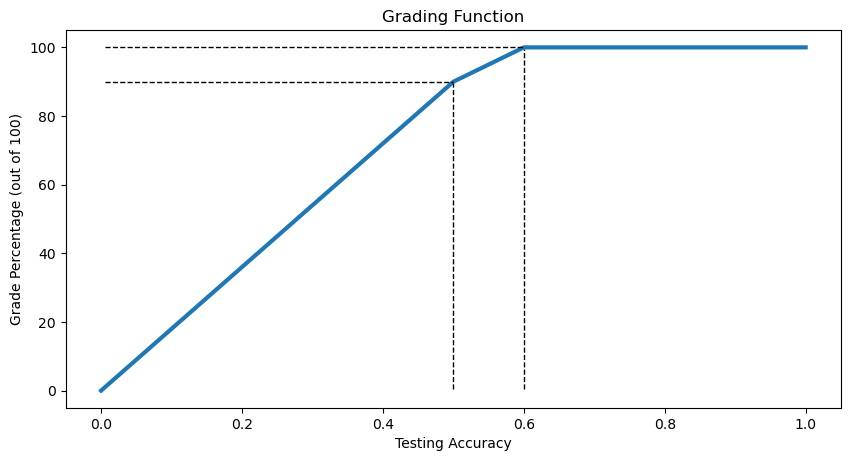

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot([0., 0.5, 0.6, 1.], [0., 90., 100., 100.], lw=3)
ax.axhline(y=90, xmin=0.05, xmax=.5, lw=1, ls='--', c='black')
ax.axvline(x=0.5, ymin=0.05, ymax=.86, lw=1, ls='--', c='black')
ax.axhline(y=100, xmin=0.05, xmax=.59, lw=1, ls='--', c='black')
ax.axvline(x=0.6, ymin=0.05, ymax=.95, lw=1, ls='--', c='black')
ax.set_xlabel('Testing Accuracy')
ax.set_ylabel('Grade Percentage (out of 100)')
ax.set_title('Grading Function')
None

# <span style="color:red">Important Notes</span>

You **should** read these notes before starting as these notes include crucial information about what is expected from you.

1. **Use Pytorch**: The autograder will only accept pytorch models.

  * Pytorch's CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html is the best starting point for this assignment. However, we will not prohibit using or learning from any other tutorial you may find online.


2. **No Downloads**: The coursera machines are disconnected from the internet. We already have downloaded the pytorch data files, and uploaded them for you. You will need to disable downloading the files if you're using data collector APIs such as `torchvision.datasets`.
  * For the CIFAR data, you should provide the `root='/home/jovyan/work/course-lib/data_cifar', download=False` arguments to the `torchvision.datasets.CIFAR10` API.
  * For the MNIST data, you should provide the `root='/home/jovyan/work/course-lib/data_mnist', download=False` arguments to the `torchvision.datasets.MNIST` API.


3. **Store the Trained Model**: The autograder can not and will not retrain your model. You are supposed to train your model, and then store your best model with the following names:

  * The CIFAR classification model must be stored at `./cifar_net.pth`. 
  * The MNIST classification model must be stored at `./mnist_net.pth`.
  * Do not place these file under any newly created directory.
  * The trained model may **not exceed 1 MB** in size.


4. **Model Class Naming**: The neural models in the pytorch library are subclasses of the `torch.nn.Module` class. While you can define any architecture as you please, your `torch.nn.Module` must be named `Net` exactly. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```


5. **Grading Reference Pre-processing**: We will use a specific randomized transformation for grading that can be found in the `Autograding and Final Tests` section. Before training any model for long periods of time, you need to pay attention to the existence of such a testing pre-processing.

6. **Training Rules**: You are able to make the following decisions about your model:

  * You **can** choose and change your architecture as you please. 
      * You can have shallow networks, or deep ones.
      * You can customize the number of neural units in each layer and the depth of the network.
      * You are free to use convolutional, and non-convolutional layers.
      * You can employ batch normalization if you would like to.
      * You can use any type of non-linear layers as you please. `Tanh`, `Sigmoid`, and `ReLU` are some common activation functions.
      * You can use any kind of pooling layers you deem appropriate.
      * etc.
   * You **can** initialize your network using any of the methods described in `https://pytorch.org/docs/stable/nn.init.html`.
      * Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.
      * You may want to avoid initializing your network with all zeros (think about the symmetry of the neural units, and how identical initialization may be a bad idea considering what happens during training).
   * You **can** use and customize any kind of optimization methods you deem appropriate.
      * You can use any first order stochastic methods (i.e., Stochastic Gradient Descent variants) such as Vanilla SGD, Adam, RMSProp, Adagrad, etc.
      * You are also welcome to use second order optimization methods such as newton and quasi-newton methods. However, it may be expensive and difficult to make them work for this setting.
      * Zeroth order methods (i.e., Black Box methods) are also okay (although you may not find them very effective in this setting).
      * You can specify any learning rates first order stochastic methods. In fact, you can even customize your learning rate schedules.
      * You are free to use any mini-batch sizes for stochastic gradient computation.
      * etc.
   * You **can** use any kind of loss function you deem effective.
      * You can add any kind of regularization to your loss.
      * You can pick any kind of classification loss functions such as the cross-entropy and the mean squared loss. 
   * You **cannot** warm-start your network (i.e., you **cannot** use a pre-trained network).
   * You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

# 1. Object Classification Using the CIFAR Data

## 1.1 Loading the Data

In [6]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

transform = transforms.Compose(
    [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/home/jovyan/work/course-lib/data_cifar', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/jovyan/work/course-lib/data_cifar', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# your code here
# raise NotImplementedError

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


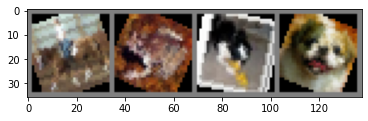

horse  frog   dog   dog


In [7]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# raise NotImplementedError

# 1.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [8]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# your code here
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.alpha_dropout ( F.celu( self.conv1(x), 0.9 ), 0.1 ) ) 
        x = self.pool(F.alpha_dropout ( F.celu( self.conv2(x), 0.9 ), 0.1 ) ) 
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# raise NotImplementedError

You can define the neural architecture and instantiate it in this cell.


# 1.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [9]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
# print(message)
# print(net)
# print(nn.init.xavier_normal_(net.conv1.weight, gain = 1)[0][1])

gain = nn.init.calculate_gain('leaky_relu', 0.2)
# print(gain)
nn.init.xavier_normal_(net.conv1.weight, gain = gain)
nn.init.xavier_normal_(net.conv2.weight, gain = gain)
nn.init.xavier_normal_(net.fc1.weight, gain = gain)
nn.init.xavier_normal_(net.fc2.weight, gain = gain)
nn.init.xavier_normal_(net.fc3.weight, gain = gain)

# your code here
# raise NotImplementedError

Parameter containing:
tensor([[ 5.6357e-02, -5.7237e-01, -1.9227e-01,  3.5276e-01,  1.5889e-02,
         -3.0655e-02, -1.1477e-01, -2.6419e-01, -4.6648e-01, -3.6514e-01,
          1.8320e-03, -1.4103e-01,  3.0335e-01, -4.4770e-01,  3.7262e-01,
          9.8880e-02,  3.1616e-02,  3.4646e-01, -7.0389e-02, -3.6781e-02,
          5.3349e-02, -6.2918e-03,  2.3753e-02, -2.7932e-01,  5.8881e-02,
         -2.2654e-01,  5.4420e-02,  4.5163e-02, -3.5548e-01, -8.7781e-02,
          1.2602e-02,  2.8328e-02,  1.0181e-01,  5.7333e-02,  2.8151e-01,
         -1.4122e-01,  2.0142e-01,  1.4189e-01,  2.4303e-01, -9.7615e-02,
         -1.5289e-01, -7.6305e-02,  9.0132e-03,  1.2161e-01,  2.2335e-01,
         -9.2094e-02,  4.1822e-02,  2.4520e-02,  3.1333e-01, -9.7074e-02,
          7.9003e-03,  1.9889e-01,  6.4882e-02, -3.3168e-01,  2.2195e-03,
          1.0699e-01, -1.1570e-01, -1.4014e-01,  6.3598e-02, -4.3367e-02,
         -2.9626e-01,  5.9932e-02, -8.5125e-02,  1.7677e-01, -2.9792e-02,
          2.0367

# 1.4 Defining The Loss Function and The Optimizer

In [10]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
# raise NotImplementedError

You can define the loss function and the optimizer of interest here.


# 1.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [11]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # your code here
    for epoch in range(15):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

# raise NotImplementedError

You can define the training loop and forward-backward propagation here.
[1,  2000] loss: 1.827
[1,  4000] loss: 1.642
[1,  6000] loss: 1.569
[1,  8000] loss: 1.528
[1, 10000] loss: 1.469
[1, 12000] loss: 1.490
[2,  2000] loss: 1.411
[2,  4000] loss: 1.414
[2,  6000] loss: 1.409
[2,  8000] loss: 1.380
[2, 10000] loss: 1.391
[2, 12000] loss: 1.378
[3,  2000] loss: 1.340
[3,  4000] loss: 1.342
[3,  6000] loss: 1.332
[3,  8000] loss: 1.347
[3, 10000] loss: 1.334
[3, 12000] loss: 1.321
[4,  2000] loss: 1.301
[4,  4000] loss: 1.315
[4,  6000] loss: 1.299
[4,  8000] loss: 1.290
[4, 10000] loss: 1.284
[4, 12000] loss: 1.300
[5,  2000] loss: 1.261
[5,  4000] loss: 1.269
[5,  6000] loss: 1.279
[5,  8000] loss: 1.254
[5, 10000] loss: 1.285
[5, 12000] loss: 1.267
[6,  2000] loss: 1.249
[6,  4000] loss: 1.258
[6,  6000] loss: 1.267
[6,  8000] loss: 1.255
[6, 10000] loss: 1.237
[6, 12000] loss: 1.246
[7,  2000] loss: 1.226
[7,  4000] loss: 1.222
[7,  6000] loss: 1.227
[7,  8000] loss: 1.259
[7, 1000

# 1.6 Storing the Model

In [12]:
message = 'Here you should store the model at "./cifar_net.pth" .'
print(message)

# your code here
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# raise NotImplementedError

Here you should store the model at "./cifar_net.pth" .


# 1.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


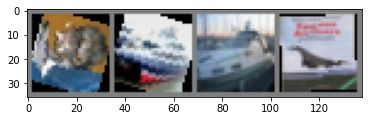

GroundTruth:    cat  ship  ship plane


In [13]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# raise NotImplementedError

In [14]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# raise NotImplementedError

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 57 %


In [15]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
# raise NotImplementedError

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy of plane : 58 %
Accuracy of   car : 69 %
Accuracy of  bird : 46 %
Accuracy of   cat : 39 %
Accuracy of  deer : 45 %
Accuracy of   dog : 46 %
Accuracy of  frog : 69 %
Accuracy of horse : 64 %
Accuracy of  ship : 72 %
Accuracy of truck : 59 %


## 1.8 Autograding and Final Tests

In [16]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

cifar_net_path = './cifar_net_submitted.pth' if in_submission else './cifar_net.pth'

assert os.path.exists(cifar_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(cifar_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'



if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(cifar_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

test_pre_tranformation = transforms.Compose(transformation_list)

cifar_root = '/home/jovyan/work/course-lib/data_cifar' 
testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False,
                                       download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of plane : 59 %
Accuracy of   car : 67 %
Accuracy of  bird : 45 %
Accuracy of   cat : 40 %
Accuracy of  deer : 46 %
Accuracy of   dog : 47 %
Accuracy of  frog : 68 %
Accuracy of horse : 65 %
Accuracy of  ship : 72 %
Accuracy of truck : 60 %
----------
Overall Testing Accuracy: 57.4 %%


In [18]:
# "Object Classification Test: Checking the accuracy on the CIFAR Images"



# 2. Digit Recognition Using the MNIST Data

## 2.1 Loading the Data

In [23]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

# your code here

transform = transforms.Compose( [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))] )

trainset = torchvision.datasets.MNIST(root='/home/jovyan/work/course-lib/data_mnist', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='/home/jovyan/work/course-lib/data_mnist', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

# raise NotImplementedError

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


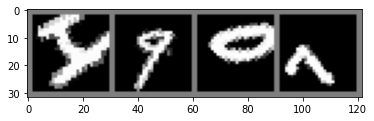

    4     9     0     7


In [24]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# raise NotImplementedError

# 2.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [25]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# your code here
# defining the model architecture

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.batch = nn.BatchNorm2d(4)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(4 * 7 * 7, 10)

#     def forward(self, x):
#         x = self.pool( self.relu( self.batch( self.conv2( self.pool( self.relu( self.batch( self.conv1(x) ) ) ) ) ) ) )
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         return x

##############################

# class Net(nn.Module):   
#   def __init__(self):
#       super(Net, self).__init__()

#       self.cnn_layers = nn.Sequential(
#           # Defining a 2D convolution layer
#           nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
#           nn.BatchNorm2d(4),
#           nn.ReLU(inplace=True),
#           nn.MaxPool2d(kernel_size=2, stride=2),
#           # Defining another 2D convolution layer
#           nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
#           nn.BatchNorm2d(4),
#           nn.ReLU(inplace=True),
#           nn.MaxPool2d(kernel_size=2, stride=2),
#       )

#       self.linear_layers = nn.Sequential(
#           nn.Linear(4 * 7 * 7, 10)
#       )

#   # Defining the forward pass    
#   def forward(self, x):
#       x = self.cnn_layers(x)
#       x = x.view(x.size(0), -1)
#       x = self.linear_layers(x)
#       return x

 ##################################
    
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
# #         self.conv2_drop = nn.AlphaDropout(p = 0.5)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)

 ##################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.conv2 = nn.Conv2d(4, 8, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1152, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net()

# raise NotImplementedError

You can define the neural architecture and instantiate it in this cell.


# 2.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [26]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here

gain = nn.init.calculate_gain('leaky_relu', 0.15)
# print(gain)

# nn.init.orthogonal_(net.conv1.weight, gain = gain)
# nn.init.orthogonal_(net.conv2.weight, gain = gain)
# nn.init.orthogonal_(net.fc1.weight, gain = gain)
# nn.init.orthogonal_(net.fc2.weight, gain = gain)

# nn.init.xavier_normal_(net.conv1.weight, gain = gain)
# nn.init.xavier_normal_(net.conv2.weight, gain = gain)
# nn.init.xavier_normal_(net.fc1.weight, gain = gain)
# nn.init.xavier_normal_(net.fc2.weight, gain = gain)

# raise NotImplementedError

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 2.4 Defining The Loss Function and The Optimizer

In [27]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
# opmtimizer = optim.Adam(net.parameters(), lr=0.01)
# optimizer = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# raise NotImplementedError

You can define the loss function and the optimizer of interest here.


# 2.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [28]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # your code here
    for epoch in range(15):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

#     raise NotImplementedError

You can define the training loop and forward-backward propagation here.
[1,  2000] loss: 2.277
[1,  4000] loss: 2.155
[1,  6000] loss: 2.094
[1,  8000] loss: 1.999
[1, 10000] loss: 1.886
[1, 12000] loss: 1.764
[1, 14000] loss: 1.686
[2,  2000] loss: 1.568
[2,  4000] loss: 1.516
[2,  6000] loss: 1.460
[2,  8000] loss: 1.425
[2, 10000] loss: 1.391
[2, 12000] loss: 1.373
[2, 14000] loss: 1.322
[3,  2000] loss: 1.314
[3,  4000] loss: 1.292
[3,  6000] loss: 1.268
[3,  8000] loss: 1.245
[3, 10000] loss: 1.254
[3, 12000] loss: 1.234
[3, 14000] loss: 1.225
[4,  2000] loss: 1.201
[4,  4000] loss: 1.194
[4,  6000] loss: 1.172
[4,  8000] loss: 1.163
[4, 10000] loss: 1.175
[4, 12000] loss: 1.154
[4, 14000] loss: 1.152
[5,  2000] loss: 1.123
[5,  4000] loss: 1.133
[5,  6000] loss: 1.142
[5,  8000] loss: 1.107
[5, 10000] loss: 1.143
[5, 12000] loss: 1.089
[5, 14000] loss: 1.108
[6,  2000] loss: 1.094
[6,  4000] loss: 1.079
[6,  6000] loss: 1.094
[6,  8000] loss: 1.103
[6, 10000] loss: 1.075
[6, 1200

# 2.6 Storing the Model

In [29]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

# your code here

PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

# raise NotImplementedError

Here you should store the model at "./mnist_net.pth" .


# 2.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


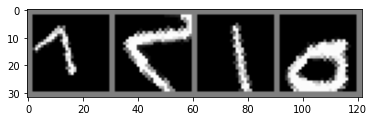

GroundTruth:      7     2     1     0


In [30]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# raise NotImplementedError

In [31]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# raise NotImplementedError

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 68 %


In [32]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
# raise NotImplementedError

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy of     0 : 72 %
Accuracy of     1 : 93 %
Accuracy of     2 : 58 %
Accuracy of     3 : 67 %
Accuracy of     4 : 73 %
Accuracy of     5 : 67 %
Accuracy of     6 : 69 %
Accuracy of     7 : 64 %
Accuracy of     8 : 50 %
Accuracy of     9 : 67 %


## 2.8 Autograding and Final Tests

In [33]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net_submitted.pth' if in_submission else './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

mnist_root = '/home/jovyan/work/course-lib/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of     0 : 89 %
Accuracy of     1 : 98 %
Accuracy of     2 : 72 %
Accuracy of     3 : 81 %
Accuracy of     4 : 86 %
Accuracy of     5 : 82 %
Accuracy of     6 : 83 %
Accuracy of     7 : 76 %
Accuracy of     8 : 66 %
Accuracy of     9 : 81 %
----------
Overall Testing Accuracy: 82.19 %%


In [34]:
# "Digit Recognition Test: Checking the accuracy on the MNIST Images"

